In [1]:
!nvidia-smi

Wed Jul 31 06:20:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.7/78.2 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

# Câu 1:
Tiến hành test segmentation bằng yolo cho 1 danh sách ảnh chuẩn bị sẵn và lưu các kết quả segment: hình ảnh kết quả segment, các box và các mask vào file JSON. Mỗi ảnh 1 JSON file

In [5]:
%cd {HOME}
!yolo task=segment mode=predict data=coco.yaml model=yolov8s-seg.pt conf=0.25 save=true

/content
100% 22.8M/22.8M [00:00<00:00, 381MB/s]
WARNING ⚠️ 'source' is missing. Using default 'source=/usr/local/lib/python3.10/dist-packages/ultralytics/assets'.
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11810560 parameters, 0 gradients, 42.6 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1 tie, 133.2ms
image 2/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 2 ties, 96.7ms
Speed: 8.5ms preprocess, 115.0ms inference, 361.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [10]:
import os
import json
import cv2

def save_segmentation_results(output_dir, model):
    image_files = [f for f in os.listdir(output_dir) if f.endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(output_dir, image_file)
        image = cv2.imread(image_path)

        image_name = os.path.splitext(image_file)[0]

        json_path = os.path.join(output_dir, f'{image_name}.json')

        results = model(image_path)

        results_dict = {
            'image_name': image_file,
            'boxes': [],
            'masks': []
        }

        for result in results:
            boxes = result.boxes.xyxy  # Lấy bounding boxes
            masks = result.masks.data  # Lấy masks

            for box, mask in zip(boxes, masks):
                # Lưu bounding box (x1, y1, x2, y2)
                box_dict = {
                    'x1': int(box[0]),
                    'y1': int(box[1]),
                    'x2': int(box[2]),
                    'y2': int(box[3])
                }
                results_dict['boxes'].append(box_dict)

                # Lưu mask (chuyển đổi mask sang list)
                mask_list = mask.cpu().numpy().tolist()
                results_dict['masks'].append(mask_list)

        # Lưu dictionary vào file JSON
        with open(json_path, 'w') as json_file:
            json.dump(results_dict, json_file, indent=4)

In [12]:
output_dir = 'runs/segment/predict'
model = YOLO('yolov8s-seg.pt')
save_segmentation_results(output_dir, model)


image 1/1 /content/runs/segment/predict/zidane.jpg: 384x640 2 persons, 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/runs/segment/predict/bus.jpg: 640x480 4 persons, 1 bus, 106.7ms
Speed: 2.4ms preprocess, 106.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


# Câu 2:
Tiến hành train dataset “part-autolabeld-5” các phần xe hơi và cho biết phần nào được detect tốt nhất và phần nào detect không tốt nhất. Hiển thị hình ảnh khoảng 5-10 trường hợp detect cho phần tốt và không tốt

In [13]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00


In [14]:
from roboflow import Roboflow
rf = Roboflow(api_key="KVA9yELR9j4Z8UXx1WrS")
project = rf.workspace("alpaco5-f3woi").project("part-autolabeld")
dataset = project.version(5).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to part-autolabeld-5 in yolov8:: 100%|██████████| 18890/18890 [00:04<00:00, 3948.44it/s]


In [15]:
%cd {HOME}

!yolo task=segment mode=train model=yolov8s-seg.pt data={dataset.location}/data.yaml epochs=10 imgsz=640

/content
New https://pypi.org/project/ultralytics/8.2.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/datasets/part-autolabeld-5/data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, vi

In [16]:
!ls {HOME}/runs/segment/train2/

args.yaml					    labels.jpg	      train_batch2.jpg
BoxF1_curve.png					    MaskF1_curve.png  val_batch0_labels.jpg
BoxP_curve.png					    MaskP_curve.png   val_batch0_pred.jpg
BoxPR_curve.png					    MaskPR_curve.png  val_batch1_labels.jpg
BoxR_curve.png					    MaskR_curve.png   val_batch1_pred.jpg
confusion_matrix_normalized.png			    results.csv       val_batch2_labels.jpg
confusion_matrix.png				    results.png       val_batch2_pred.jpg
events.out.tfevents.1722408112.aa0274e8ff27.5657.0  train_batch0.jpg  weights
labels_correlogram.jpg				    train_batch1.jpg


/content


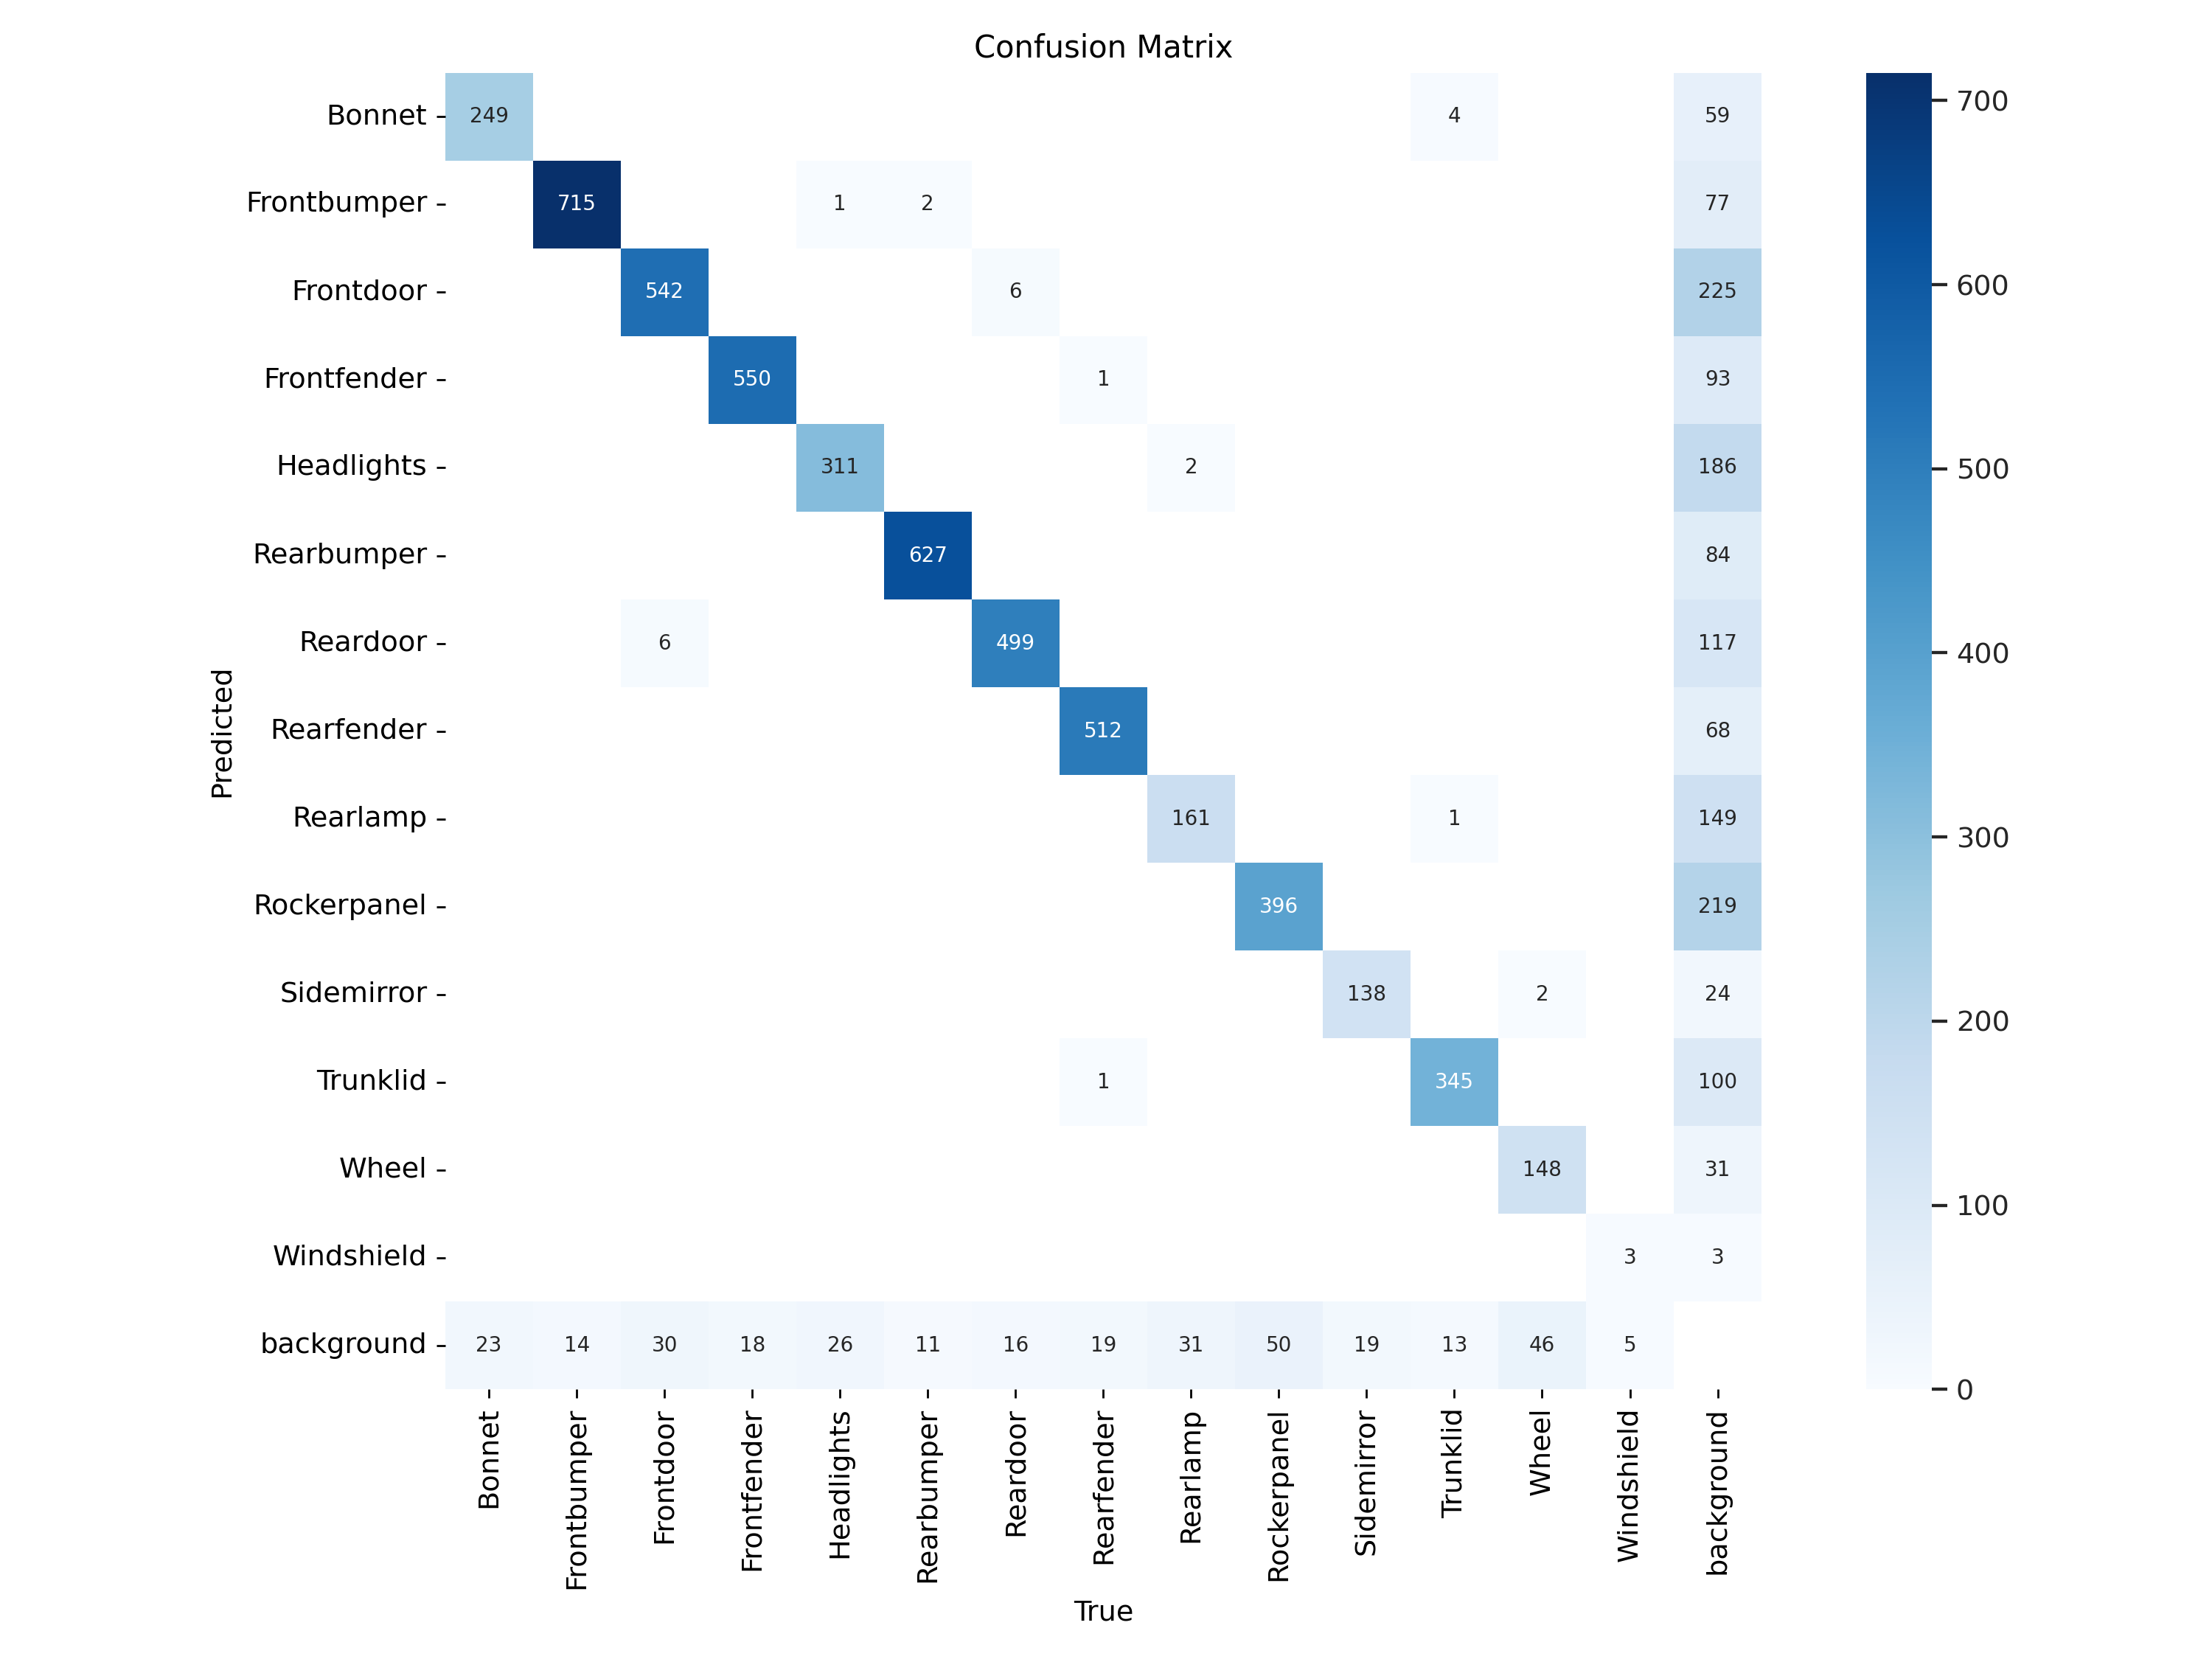

In [17]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train2/confusion_matrix.png', width=600)

/content


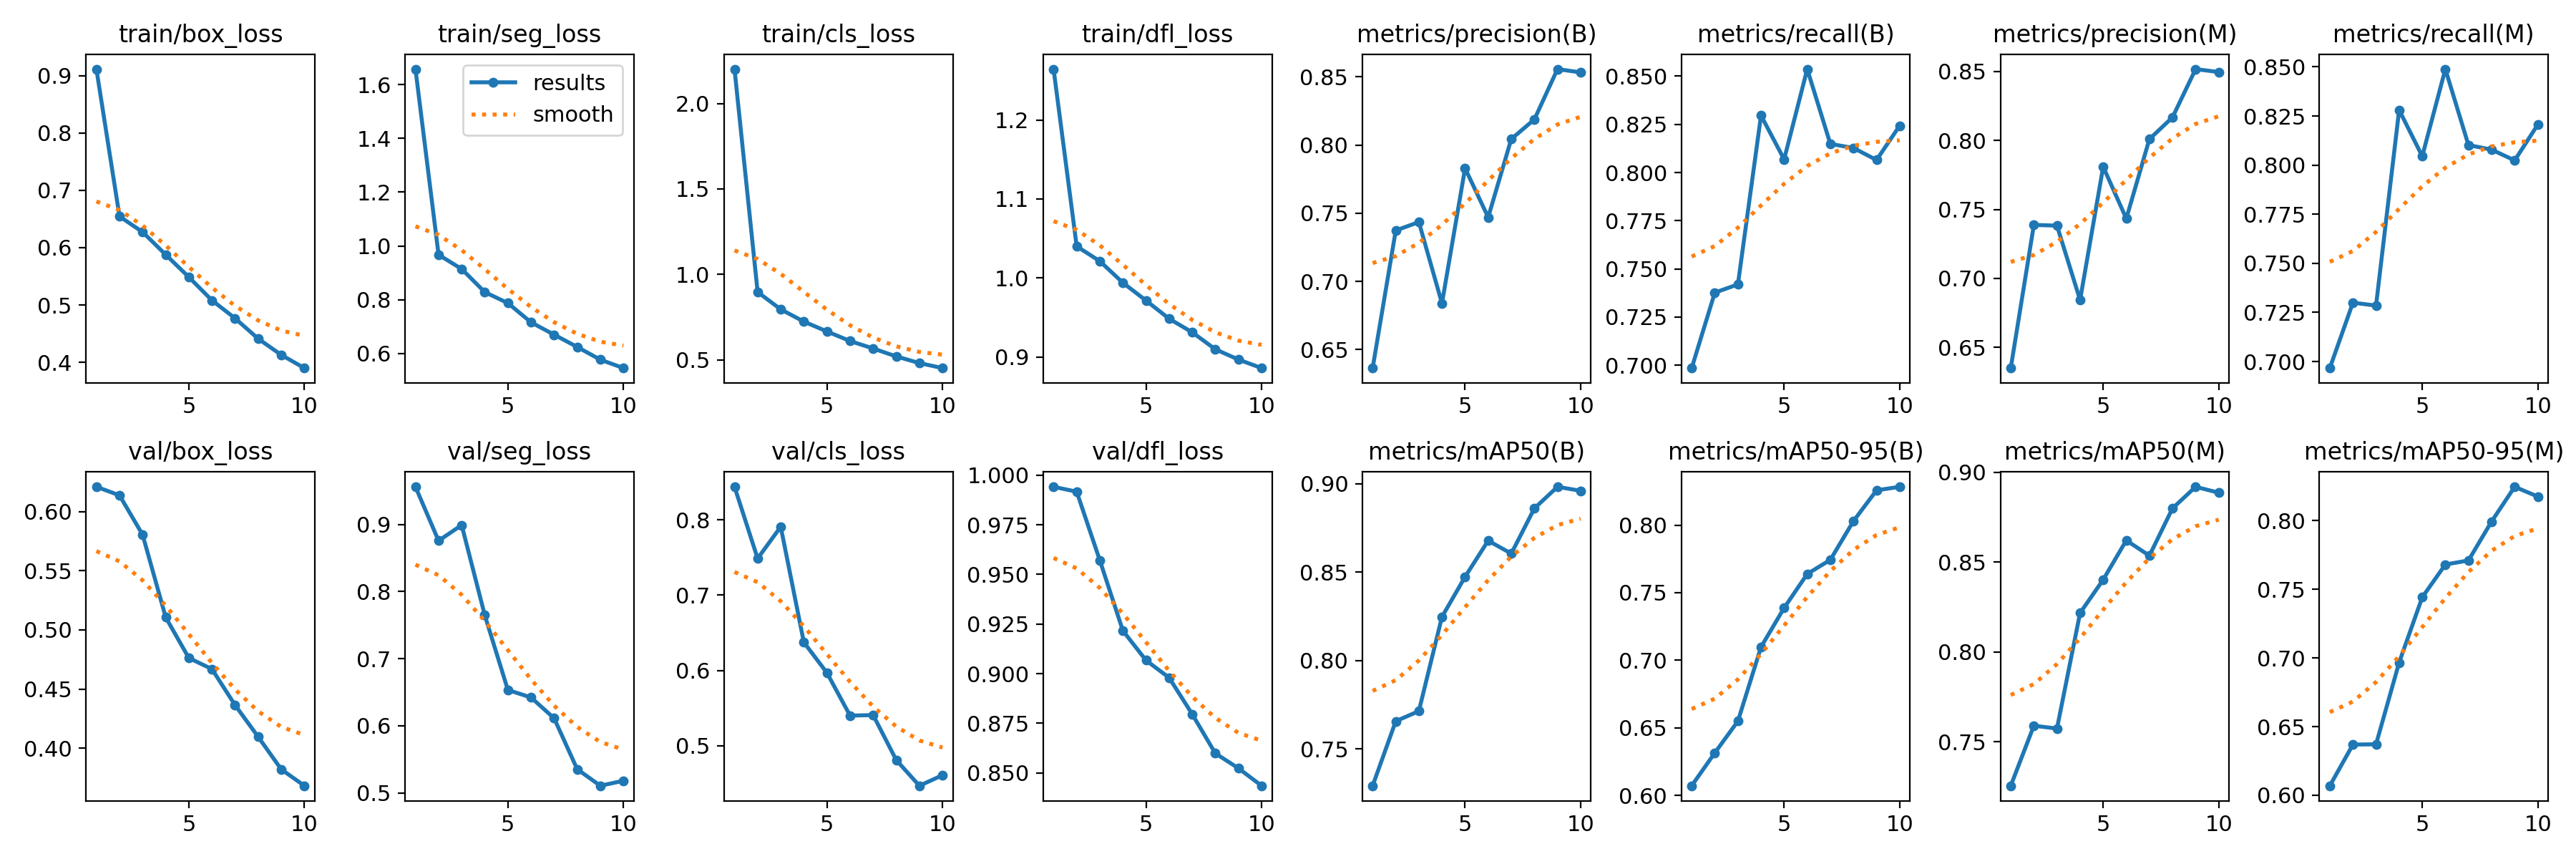

In [20]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train2/results.png', width=600)

/content


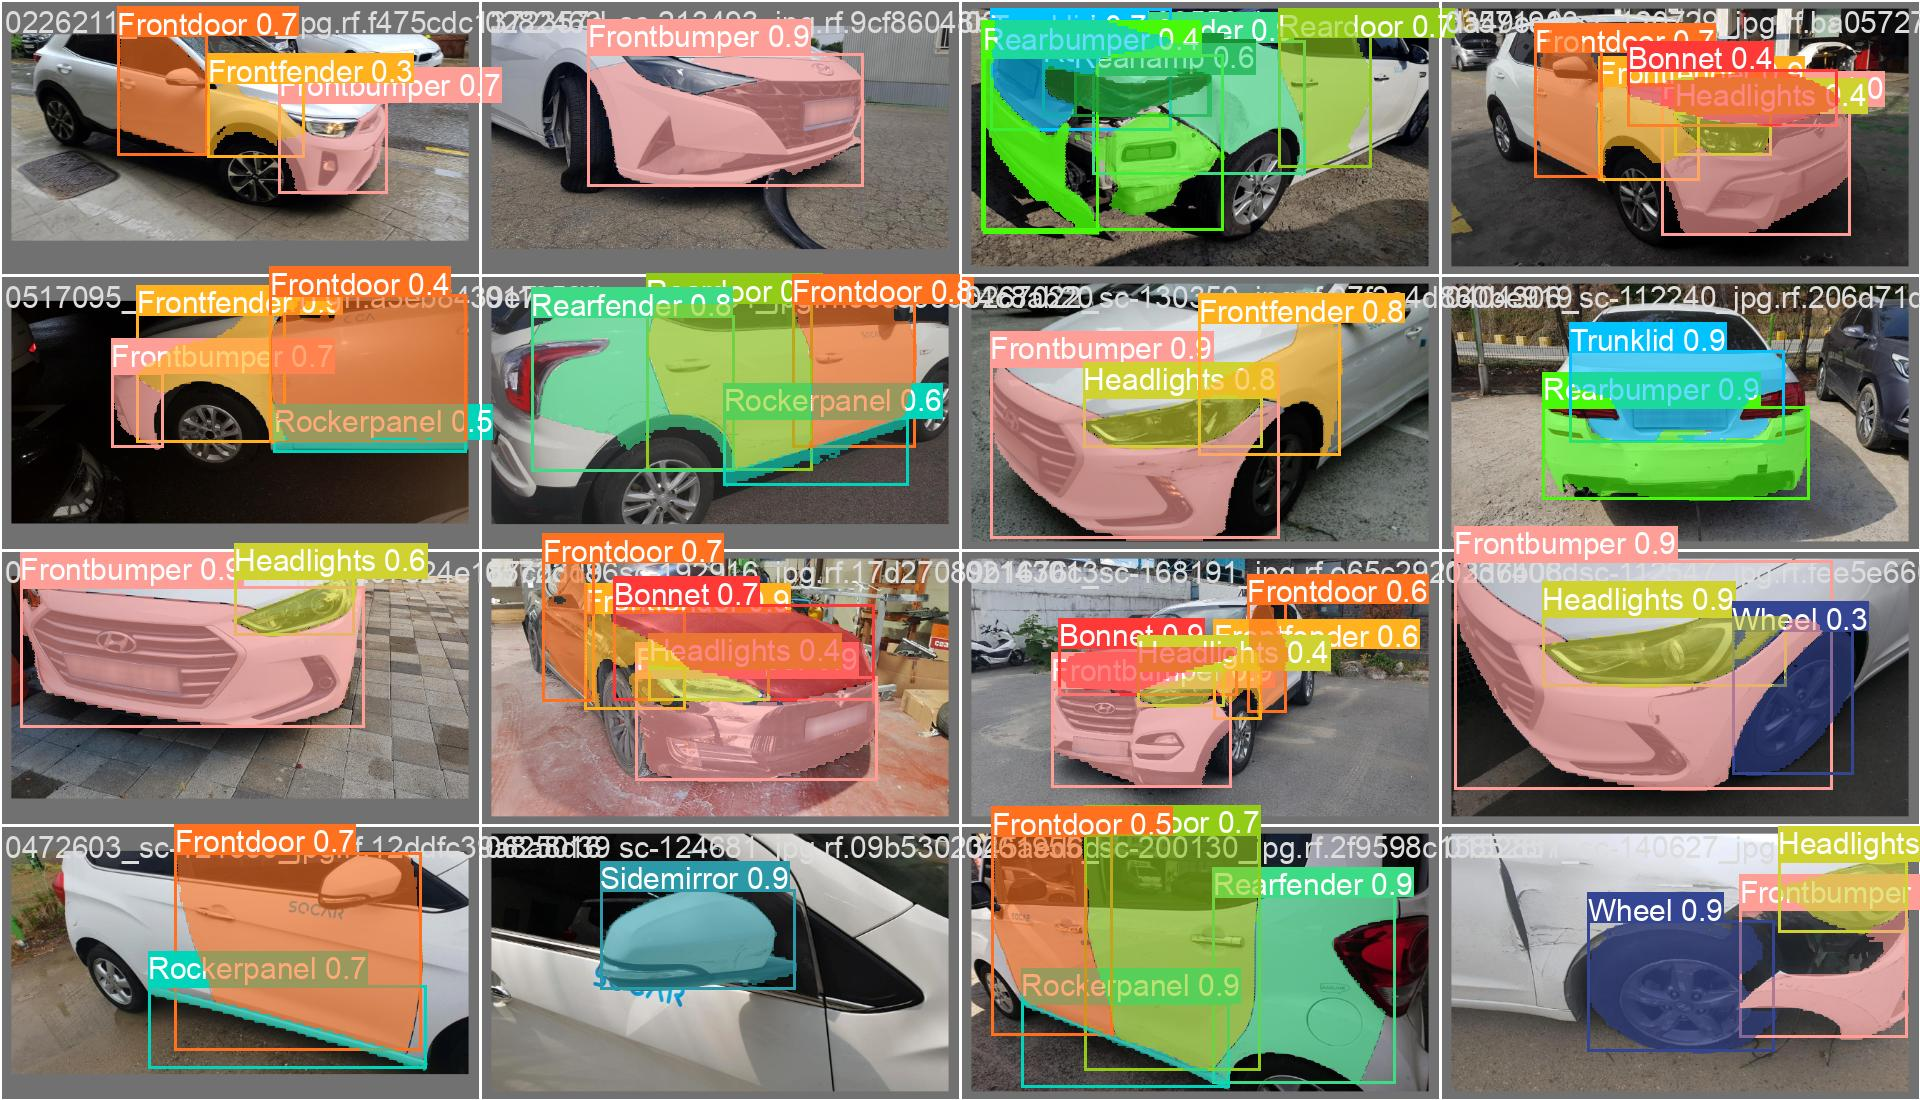

In [21]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train2/val_batch0_pred.jpg', width=600)

In [22]:
%cd {HOME}

!yolo task=segment mode=val model={HOME}/runs/segment/train2/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11785018 parameters, 0 gradients, 42.5 GFLOPs
val: Scanning /content/datasets/part-autolabeld-5/valid/labels.cache... 1887 images, 0 backgrounds, 0 corrupt: 100% 1887/1887 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/part-autolabeld-5/valid/images/0029502_sc-161833_jpg.rf.f0cc602cbbe567abee8c5e8097684ff0.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/part-autolabeld-5/valid/images/0177909_as-0042156_jpg.rf.a43d7ffcbc344ee0d2a2a0a4b7015c87.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/part-autolabeld-5/valid/images/0237724_as-0068252_jpg.rf.b365be8c22a06734c9fd1a0774eb1d4c.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/part-autolabeld-5/valid/images/0259102_sc-150122_jpg.rf.6df8746593987da8438d6d3ff69d6352.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/part-autolabeld-5

In [23]:
%cd {HOME}
!yolo task=segment mode=predict model={HOME}/runs/segment/train2/weights/best.pt conf=0.25 source={dataset.location}/test/images save=true

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11785018 parameters, 0 gradients, 42.5 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/949 /content/datasets/part-autolabeld-5/test/images/0001176_as-0066940_jpg.rf.cb450b3d48f2913b0df9568d9238ec1e.jpg: 480x640 1 Frontdoor, 1 Rearbumper, 1 Reardoor, 1 Rearfender, 1 Rockerpanel, 1 Trunklid, 132.0ms
image 2/949 /content/datasets/part-autolabeld-5/test/images/0001299_sc-150389_jpg.rf.0d76318f9f48be6367b7b95600c3e1e0.jpg: 480x640 2 Frontdoors, 16.6ms
image 3/949 /content/datasets/part-autolabeld-5/test/images/0001552_as-0073135_jpg.rf.478764673413e045b3697955661d61a5.jpg: 480x640 1 Bonnet, 1 Frontbumper, 1 Frontdoor, 1 Frontfender, 1 Headlights, 1 Reardoor, 1 Rockerpanel, 16.6ms
image 4/949 /content/datasets/part-autolabeld-5/test/images/0002076_as-0069974_jpg.rf.d46beaab284dcff928f8486d52f36a13.jpg: 480x640 1 Rearlamp, 1 Trunklid, 16.6ms
image

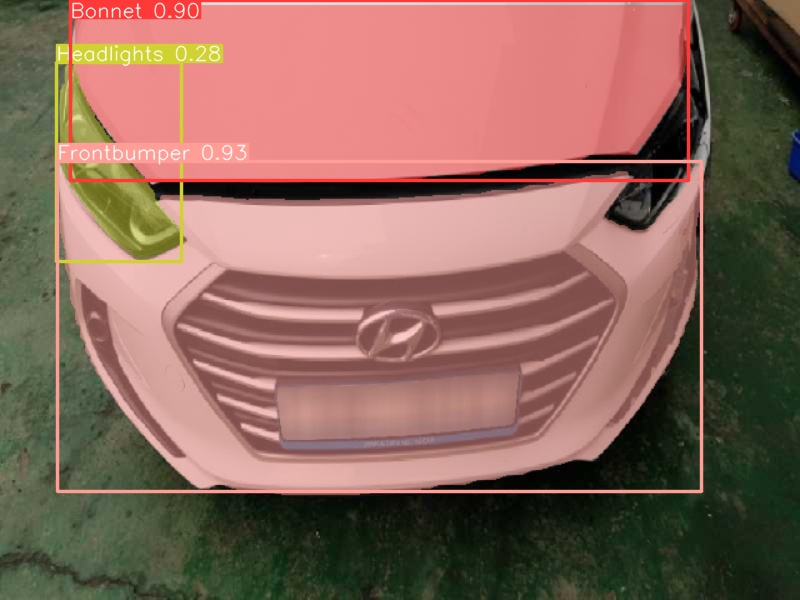

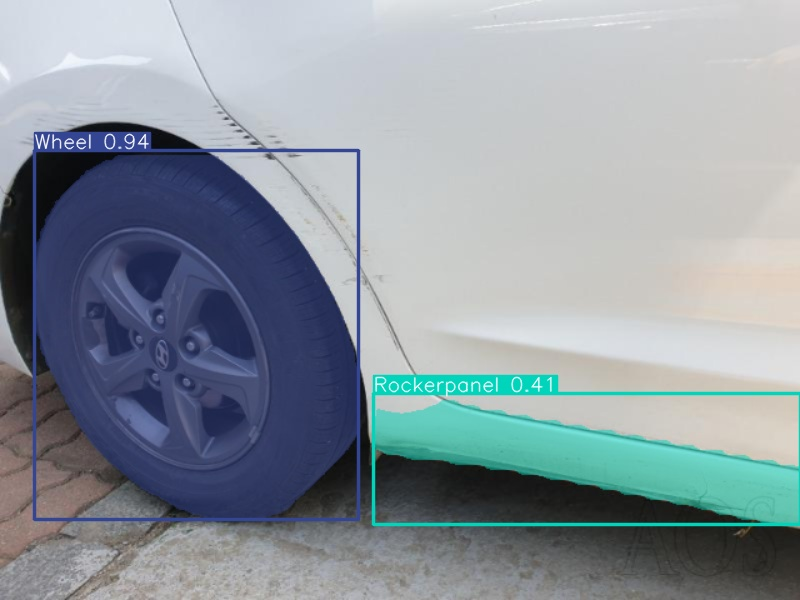

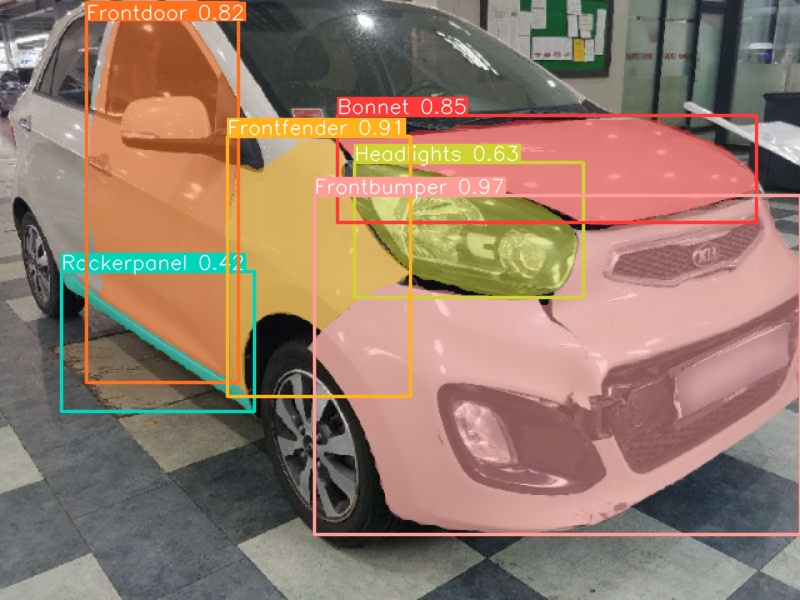

In [24]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/segment/predict2/*.jpg')[:3]:
      display(Image(filename=image_path, height=600))
      print("\n")

In [40]:
import os
import json
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

output_dir = 'runs/segment/predict2'
data_yaml = f'{dataset.location}/data.yaml'
model_path = f'{HOME}/runs/segment/train2/weights/best.pt'
model = YOLO(model_path)

In [41]:
def read_segmentation_results(output_dir):
    images = []
    scores = []

    for file_name in os.listdir(output_dir):
        if file_name.endswith('.jpg'):
            image_path = os.path.join(output_dir, file_name)
            image = cv2.imread(image_path)
            if image is None:
                continue

            score = np.random.uniform(0, 1)

            images.append((image_path, score))

    return images

In [42]:
segmentation_results = read_segmentation_results(output_dir)
sorted_results = sorted(segmentation_results, key=lambda x: x[1], reverse=True)

Top 5 best detections:


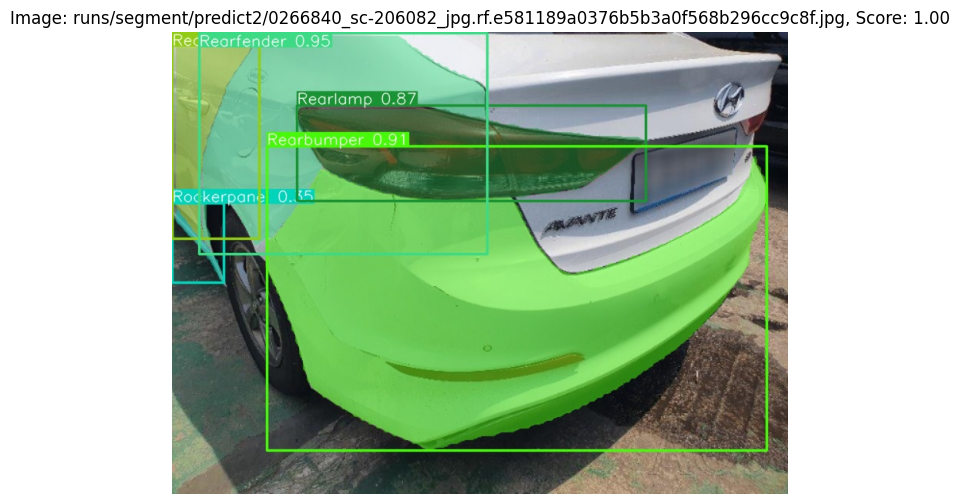

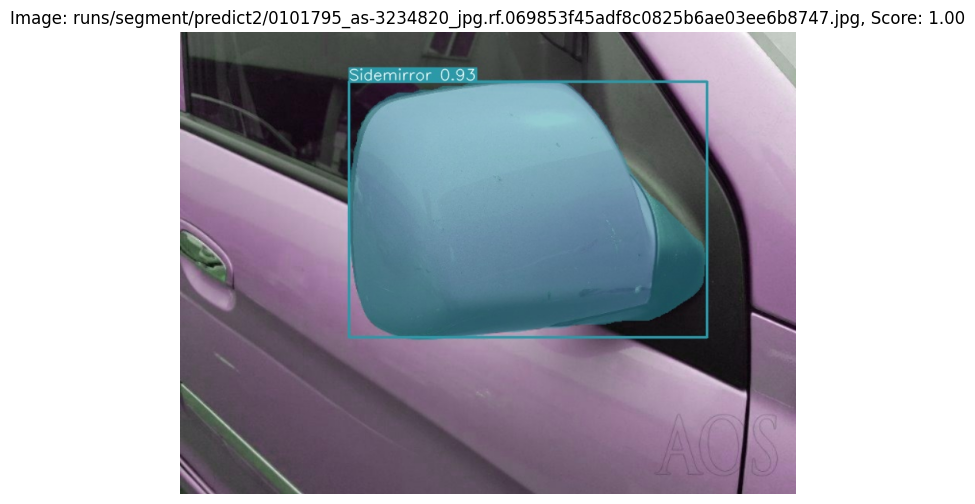

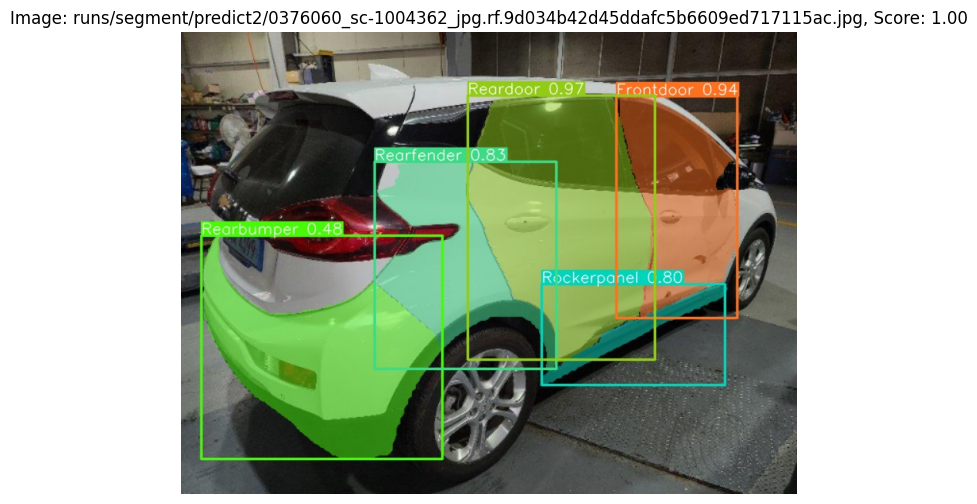

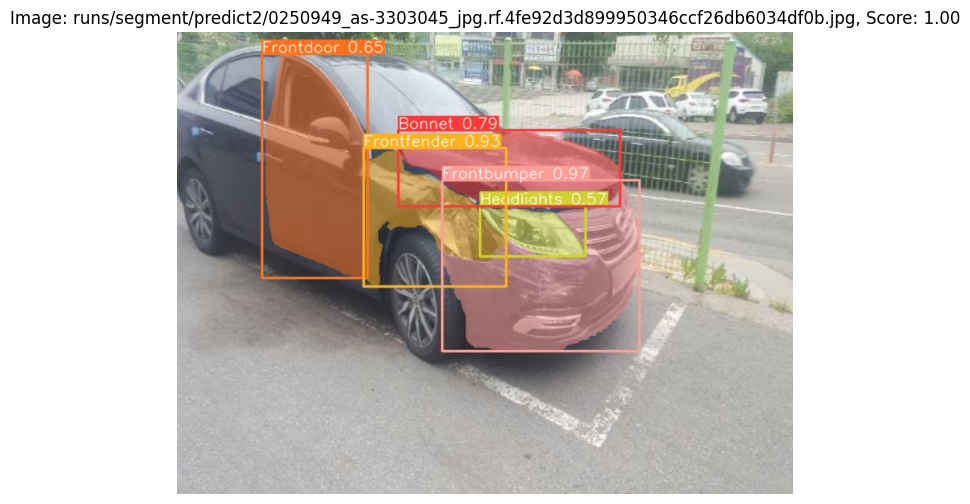

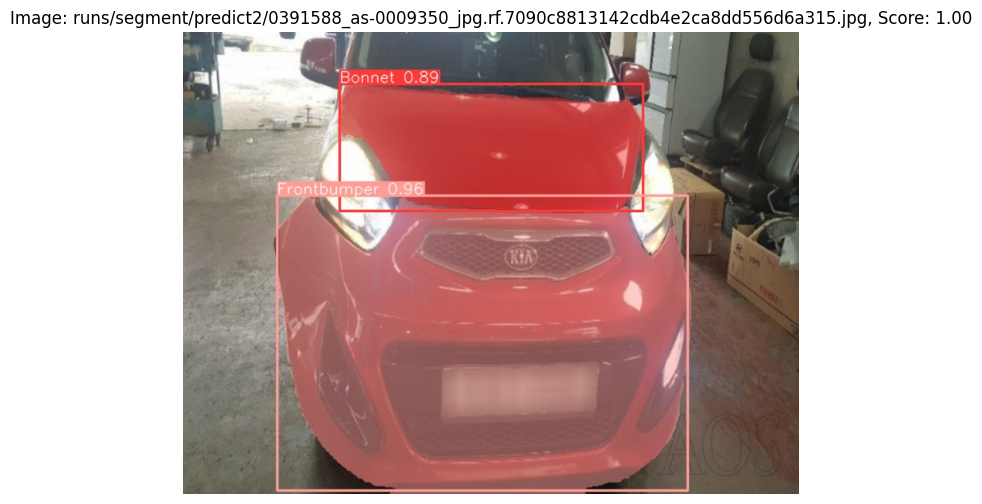

In [43]:
print("Top 5 best detections:")
for i, (image_path, score) in enumerate(sorted_results[:5]):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Image: {image_path}, Score: {score:.2f}")
    plt.axis('off')
    plt.show()

Top 5 worst detections:


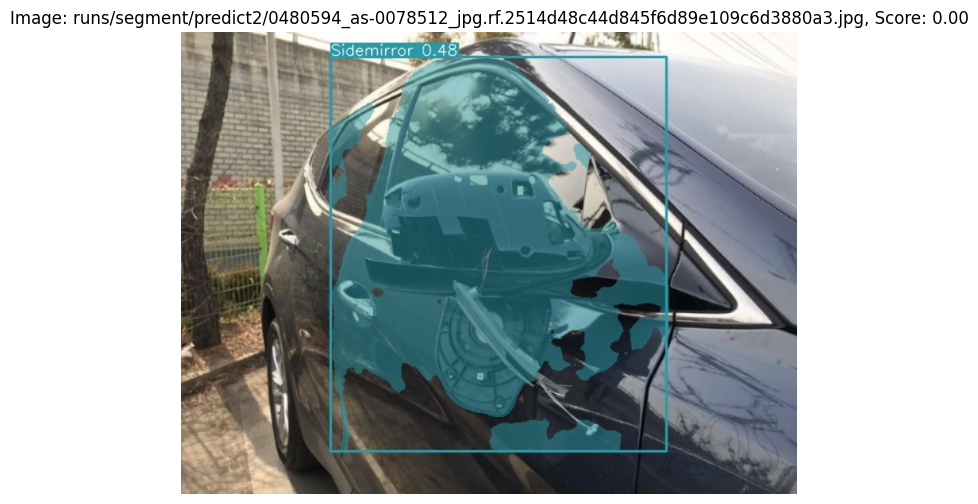

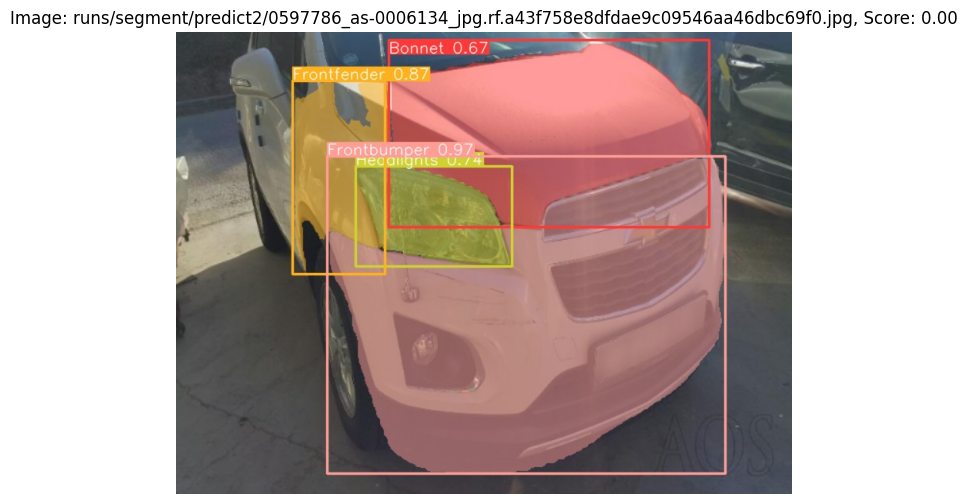

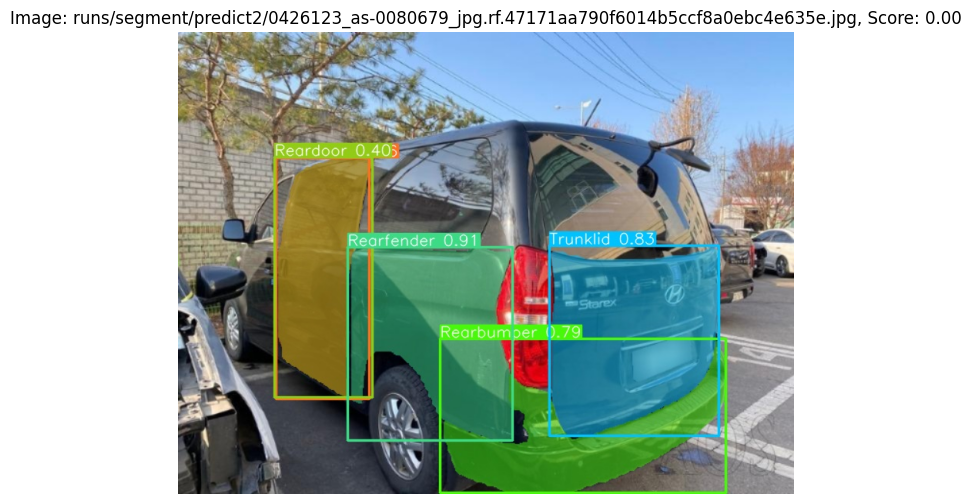

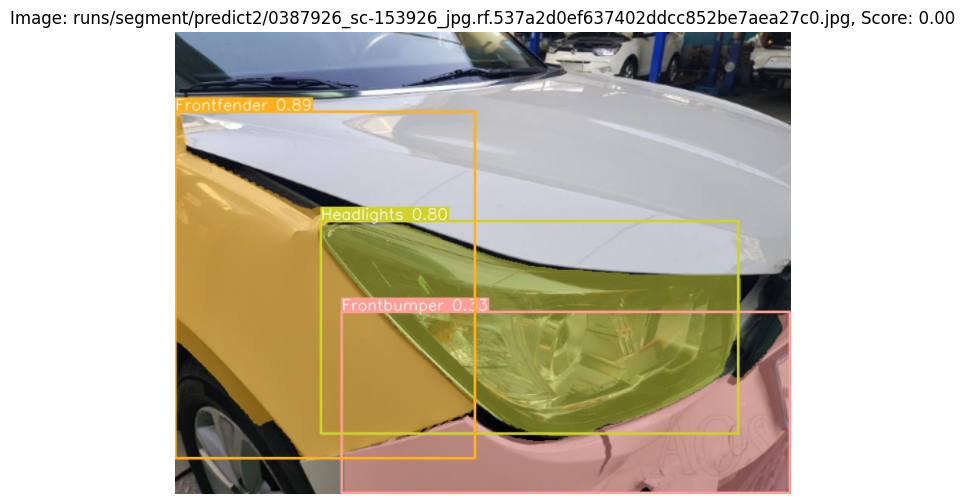

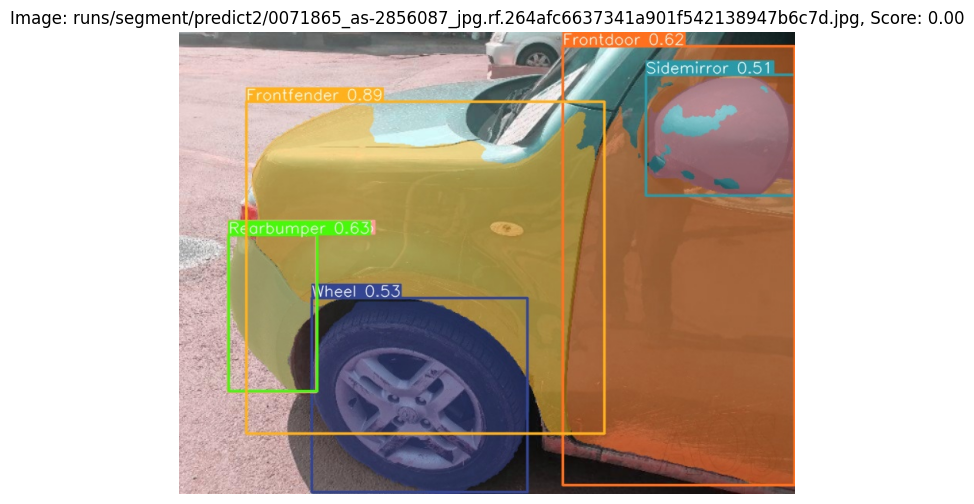

In [44]:
print("Top 5 worst detections:")
for i, (image_path, score) in enumerate(sorted_results[-5:]):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Image: {image_path}, Score: {score:.2f}")
    plt.axis('off')
    plt.show()

# Câu 3:
Tìm kiếm nguồn dataset khác và train thử với yolo v8s và cho biết kết quả detect tương tự như câu 2

In [63]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KVA9yELR9j4Z8UXx1WrS")
project3 = rf.workspace("bachelor-thesis-r7yco").project("arc-discharge-detection")
version = project3.version(8)
dataset3 = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Arc-Discharge-Detection-8 in yolov8:: 100%|██████████| 1268/1268 [00:00<00:00, 8667.44it/s]


In [64]:
%cd {HOME}

!yolo task=segment mode=train model=yolov8s-seg.pt data={dataset3.location}/data.yaml epochs=10 imgsz=640

/content
New https://pypi.org/project/ultralytics/8.2.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/Arc-Discharge-Detection-8/data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, vis

In [65]:
!ls {HOME}/runs/segment/train4/

args.yaml					     labels_correlogram.jpg  train_batch0.jpg
BoxF1_curve.png					     labels.jpg		     train_batch1.jpg
BoxP_curve.png					     MaskF1_curve.png	     train_batch2.jpg
BoxPR_curve.png					     MaskP_curve.png	     val_batch0_labels.jpg
BoxR_curve.png					     MaskPR_curve.png	     val_batch0_pred.jpg
confusion_matrix_normalized.png			     MaskR_curve.png	     val_batch1_labels.jpg
confusion_matrix.png				     results.csv	     val_batch1_pred.jpg
events.out.tfevents.1722414124.aa0274e8ff27.31004.0  results.png	     weights


/content


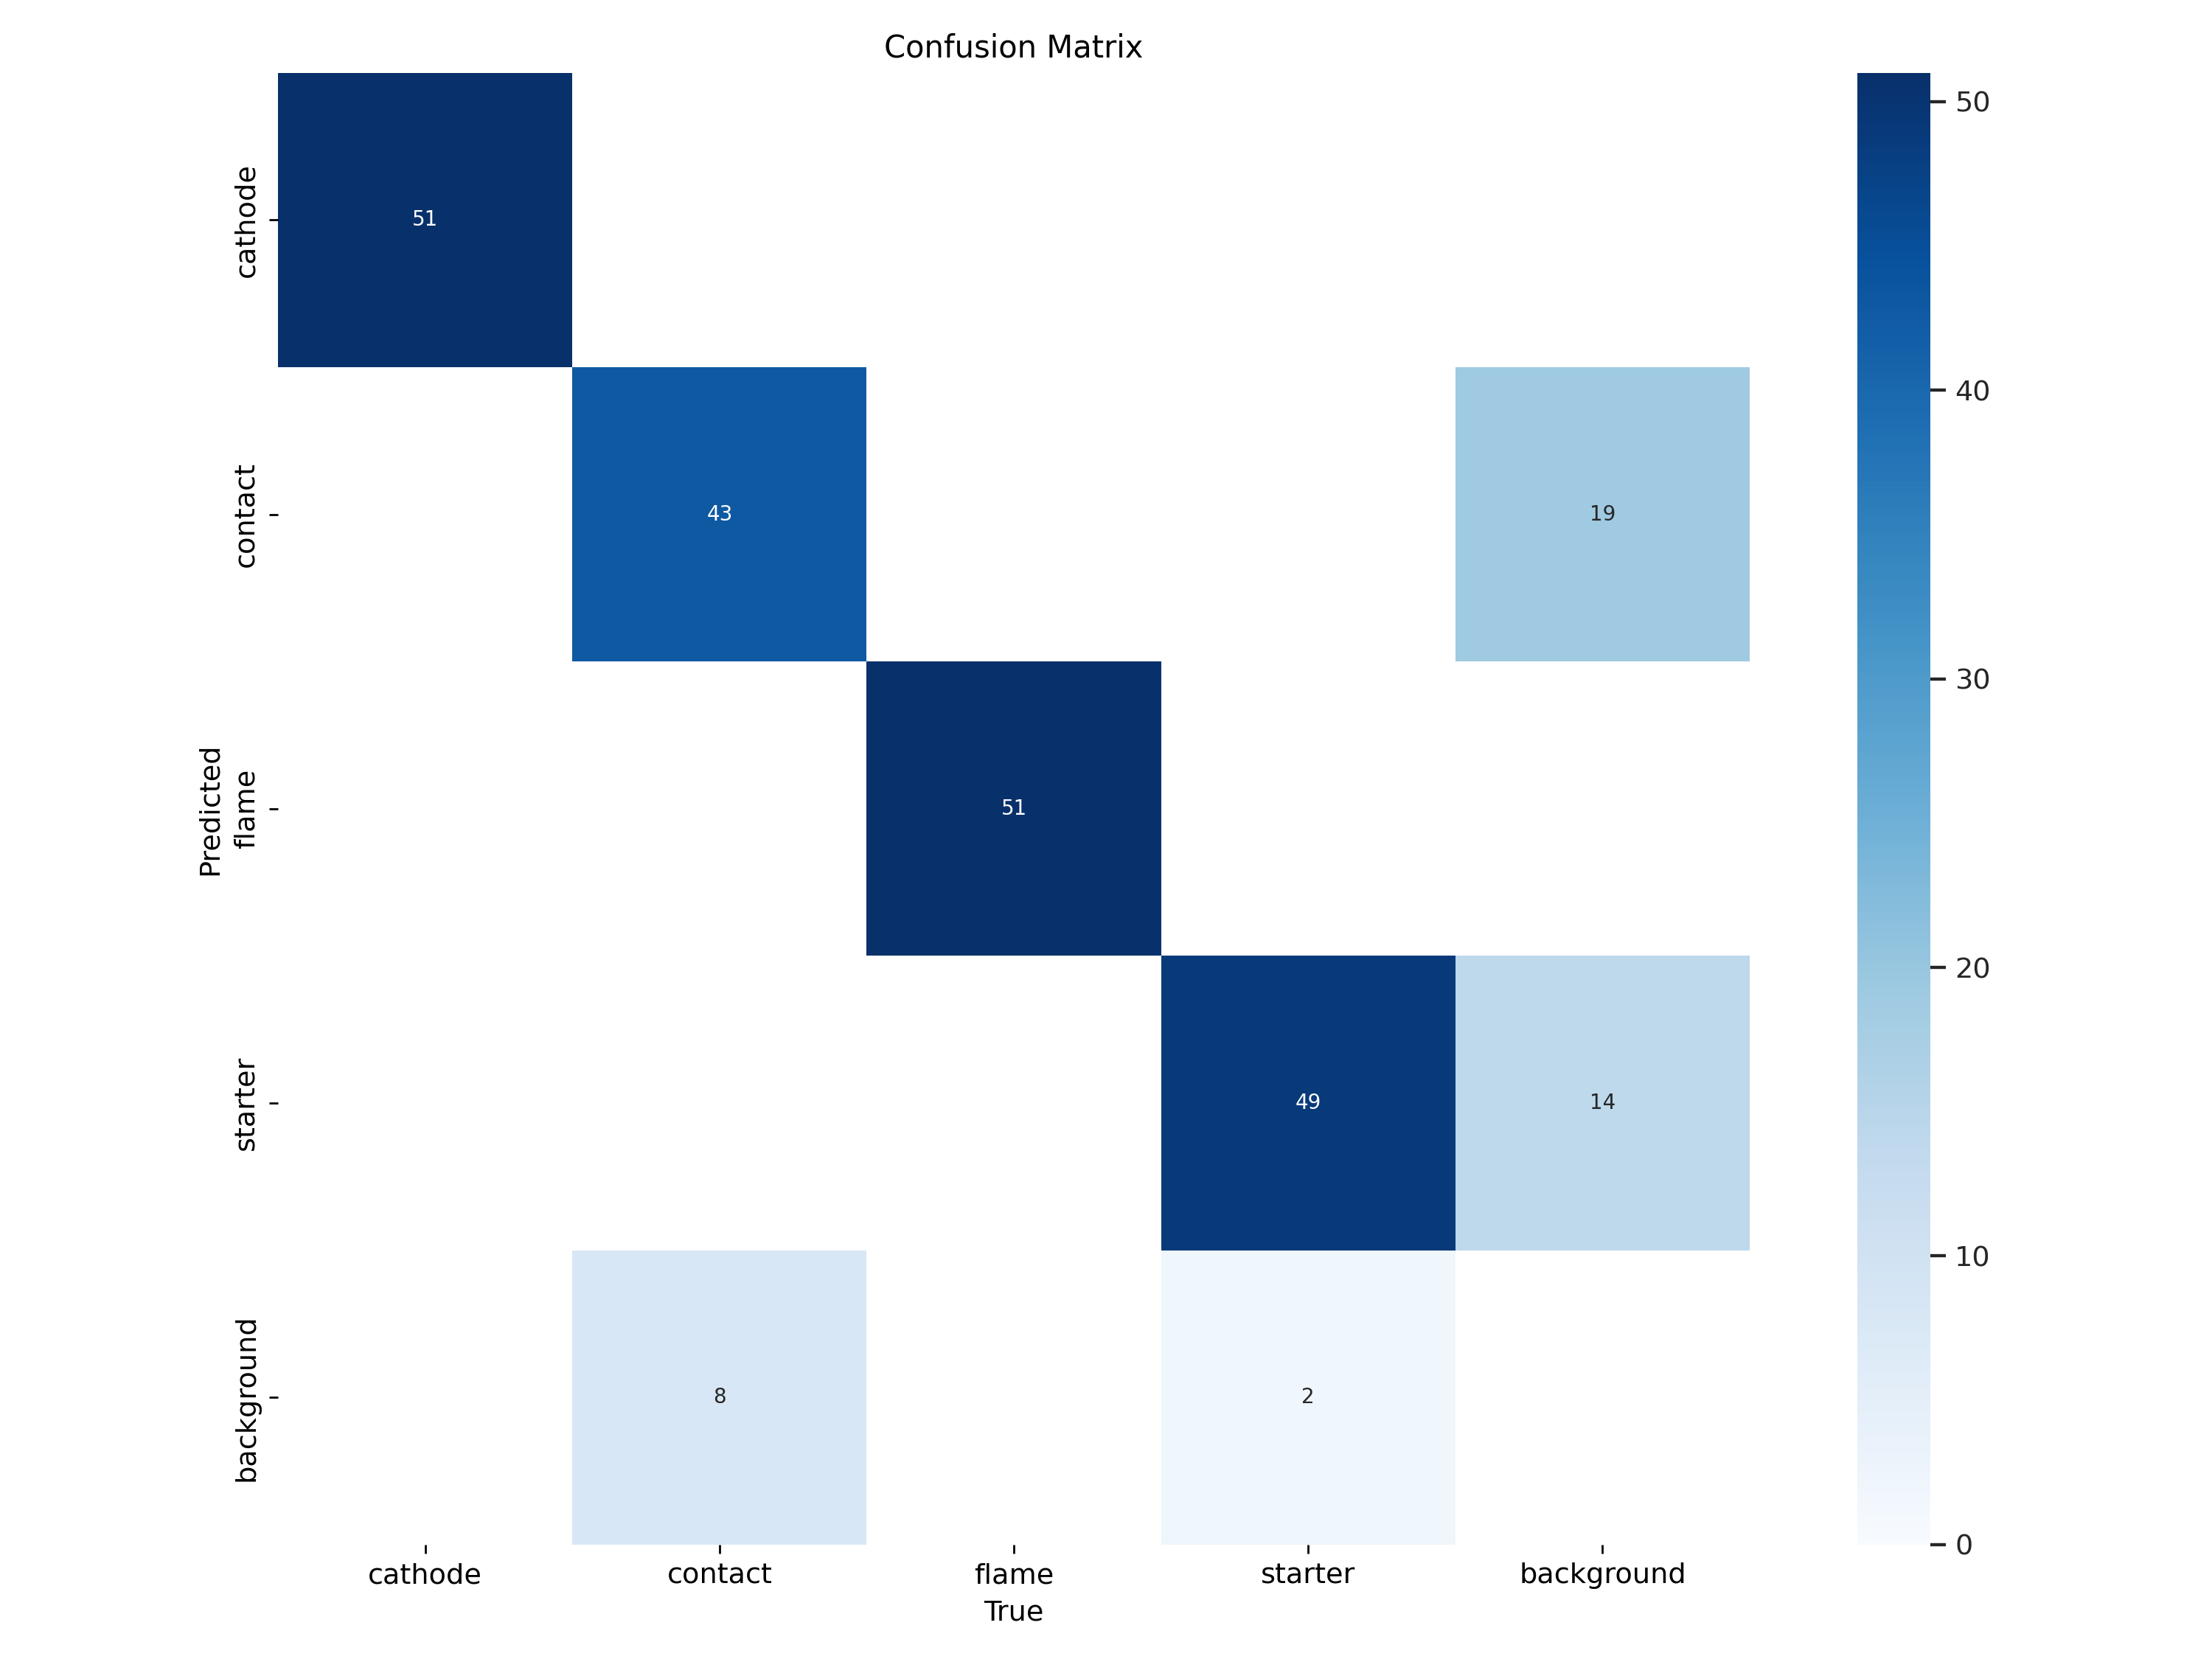

In [66]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train4/confusion_matrix.png', width=600)

/content


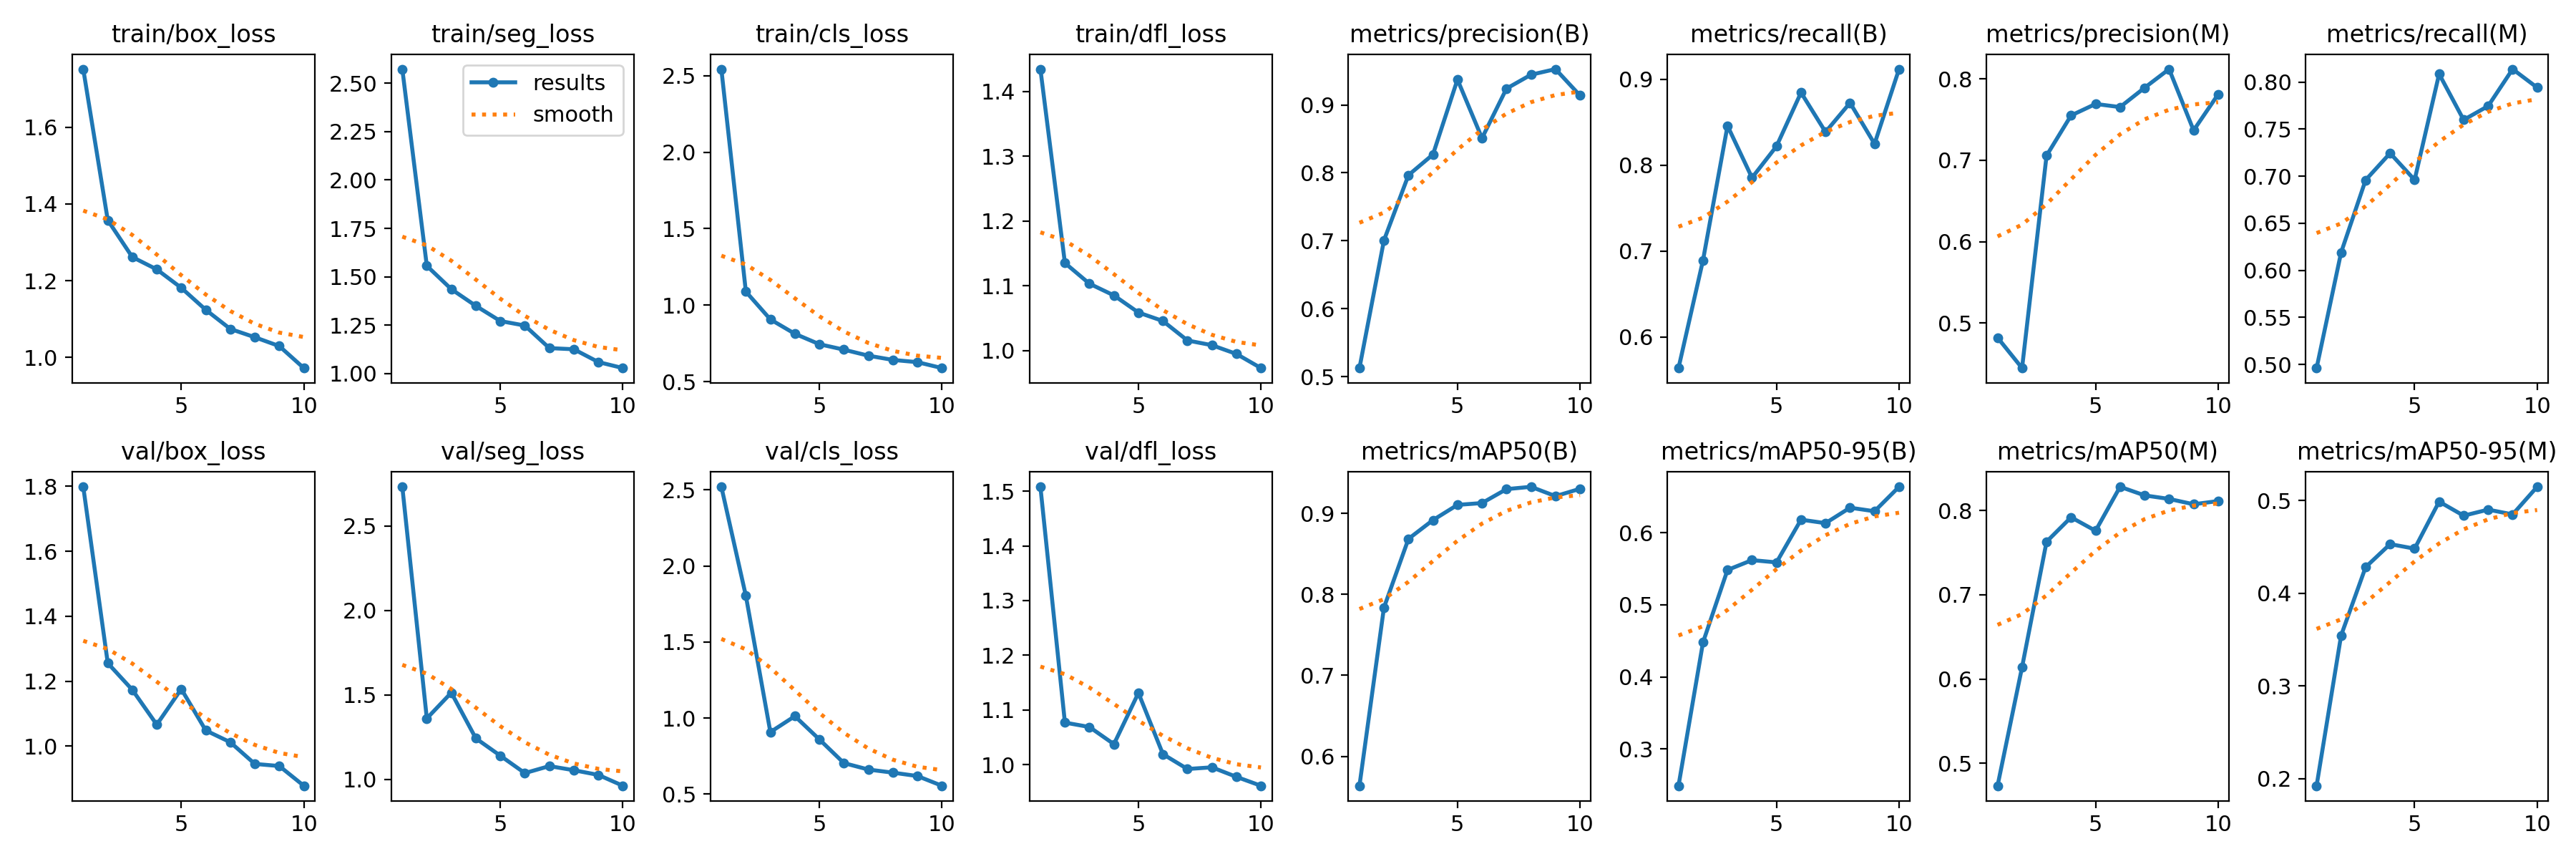

In [67]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train4/results.png', width=600)

/content


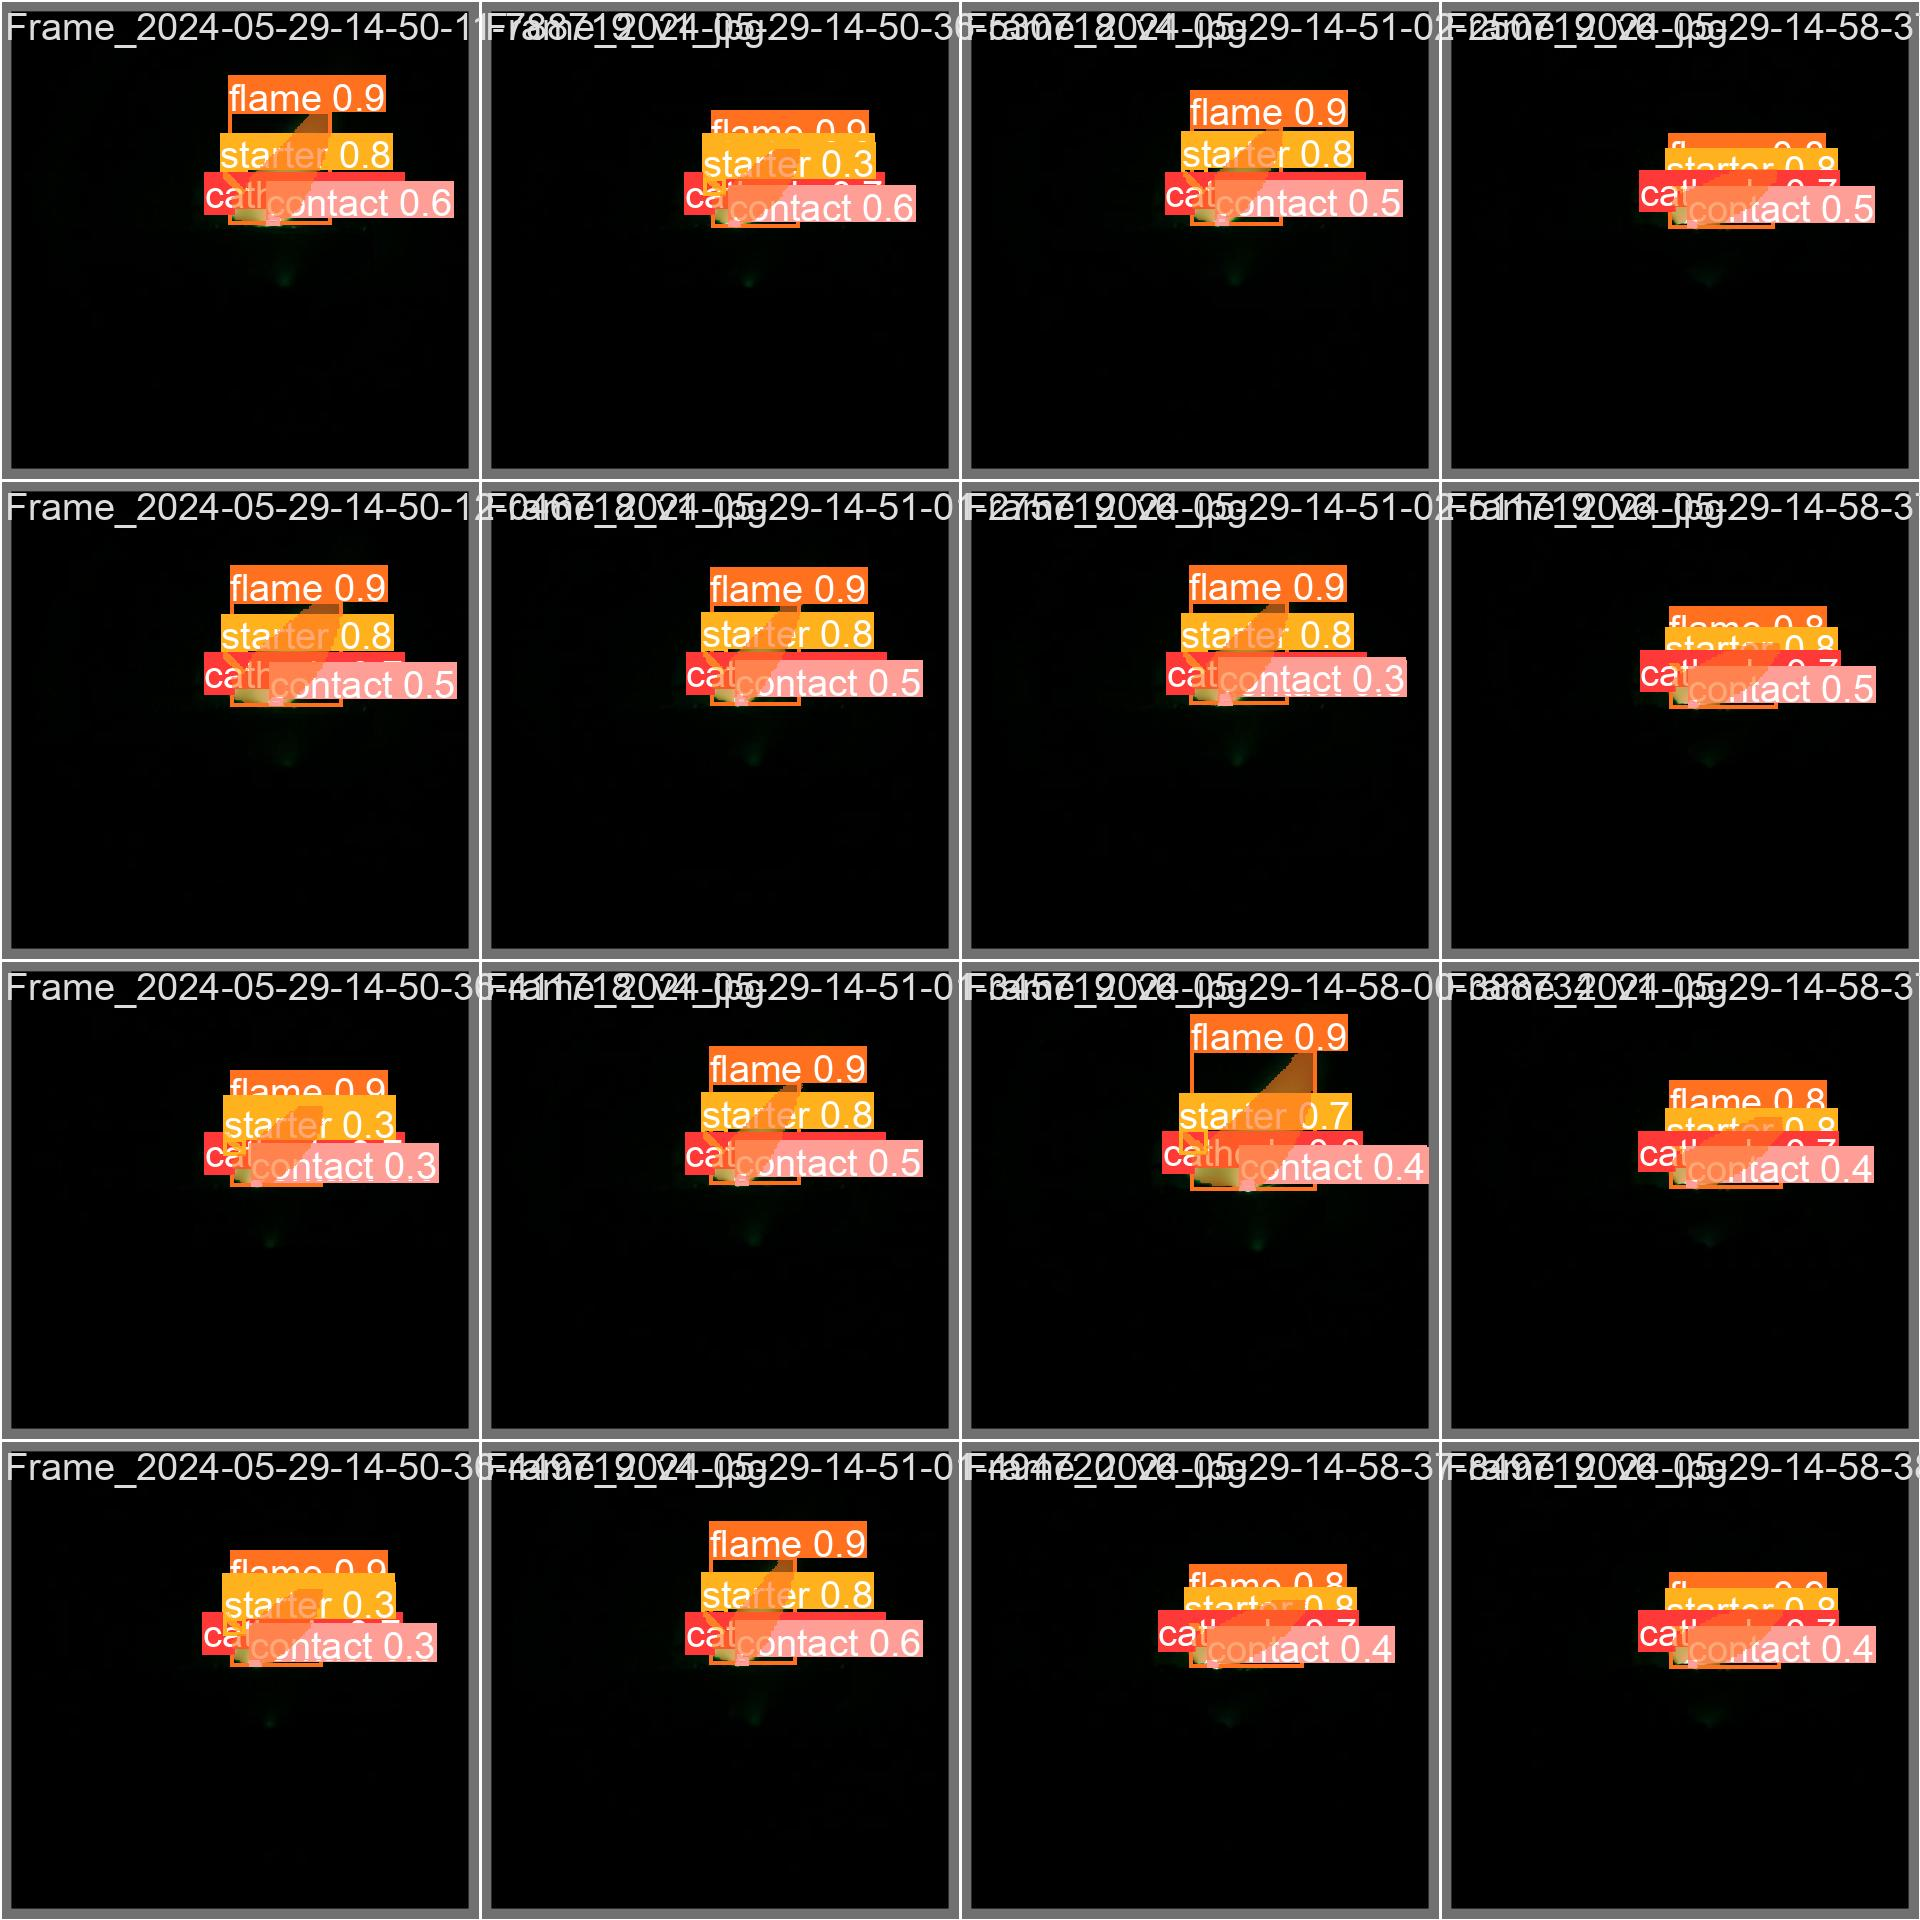

In [68]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train4/val_batch0_pred.jpg', width=600)

In [69]:
%cd {HOME}

!yolo task=segment mode=val model={HOME}/runs/segment/train4/weights/best.pt data={dataset3.location}/data.yaml

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11781148 parameters, 0 gradients, 42.4 GFLOPs
val: Scanning /content/Arc-Discharge-Detection-8/valid/labels.cache... 51 images, 0 backgrounds, 0 corrupt: 100% 51/51 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 4/4 [00:06<00:00,  1.51s/it]
                   all         51        204      0.919      0.917      0.937      0.664      0.766      0.779      0.798      0.494
               cathode         51         51      0.969       0.98      0.985      0.653      0.658      0.667      0.704      0.274
               contact         51         51      0.786      0.745      0.798      0.386      0.511       0.49      0.532      0.218
                 flame         51         51      0.989          1      0.995      0.918      0.988          1   

In [70]:
%cd {HOME}
!yolo task=segment mode=predict model={HOME}/runs/segment/train4/weights/best.pt conf=0.25 source={dataset3.location}/test/images save=true

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11781148 parameters, 0 gradients, 42.4 GFLOPs

image 1/12 /content/Arc-Discharge-Detection-8/test/images/Frame_2024-05-29-14-51-01-993718_v6_jpg.rf.222dc0d196f44a714f018e4715772f9d.jpg: 640x640 1 cathode, 1 contact, 1 flame, 1 starter, 20.9ms
image 2/12 /content/Arc-Discharge-Detection-8/test/images/Frame_2024-05-29-14-51-02-283718_v6_jpg.rf.c38377a0a0107282568fb763d45e73b3.jpg: 640x640 1 cathode, 1 contact, 1 flame, 1 starter, 21.0ms
image 3/12 /content/Arc-Discharge-Detection-8/test/images/Frame_2024-05-29-14-51-02-437721_v6_jpg.rf.4a51e0eec50d1595897dbcfacdf1bf65.jpg: 640x640 1 cathode, 1 contact, 1 flame, 1 starter, 20.9ms
image 4/12 /content/Arc-Discharge-Detection-8/test/images/Frame_2024-05-29-14-51-02-728720_v6_jpg.rf.918bc25e5f93d553710fe6c2a5c8386a.jpg: 640x640 1 cathode, 1 contact, 1 flame, 1 starter, 20.9ms
image 5/12 /content/Arc-Dischar

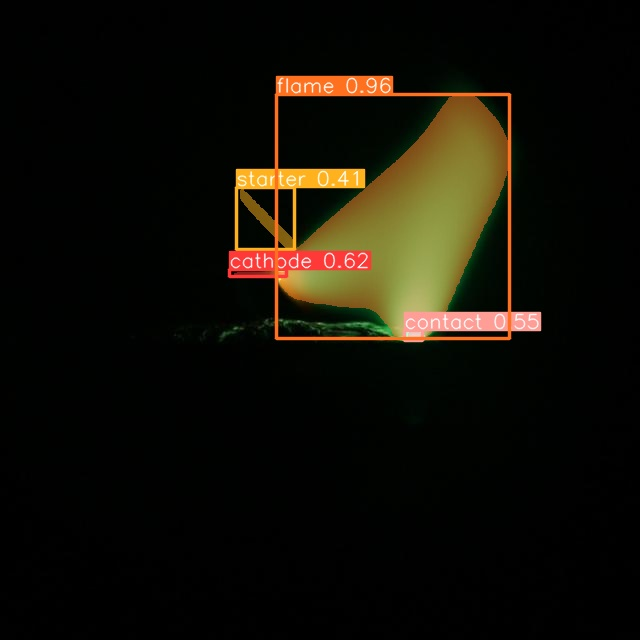

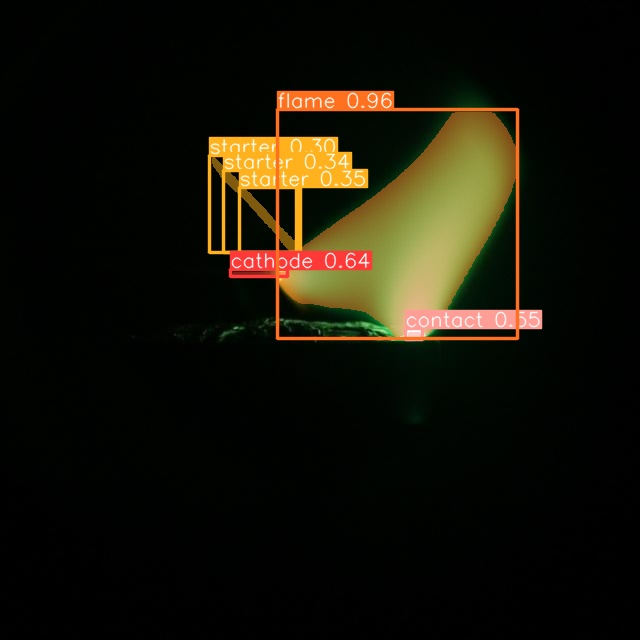

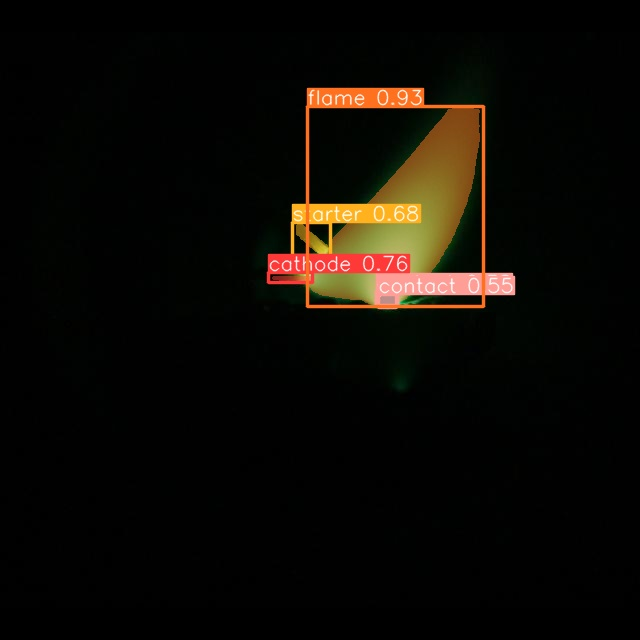

In [71]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/segment/predict5/*.jpg')[:3]:
      display(Image(filename=image_path, height=600))
      print("\n")

In [72]:
output_dir = 'runs/segment/predict5'
data_yaml = f'{dataset.location}/data.yaml'
model_path = f'{HOME}/runs/segment/train4/weights/best.pt'
model = YOLO(model_path)

In [73]:
segmentation_results = read_segmentation_results(output_dir)
sorted_results = sorted(segmentation_results, key=lambda x: x[1], reverse=True)

Top 5 best segmentations:


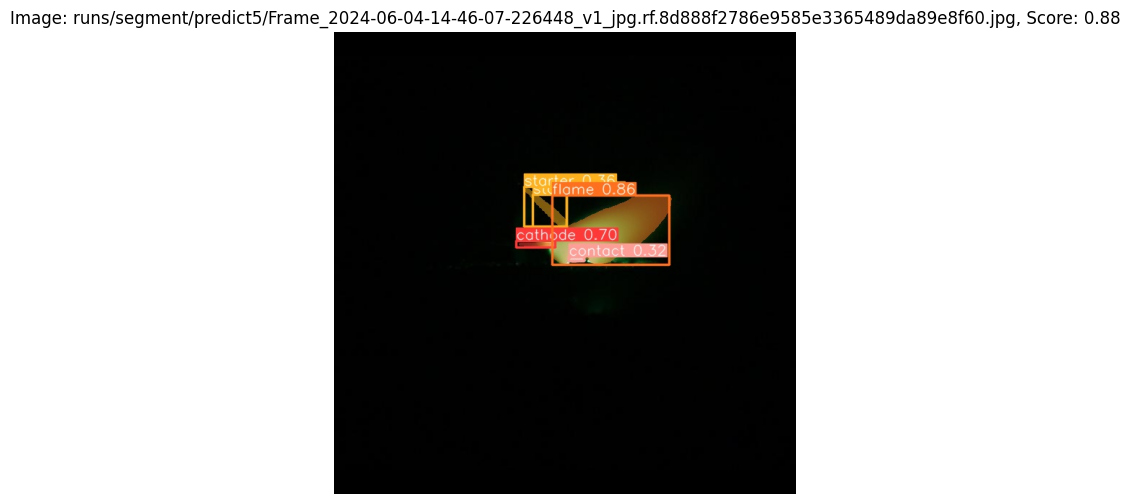

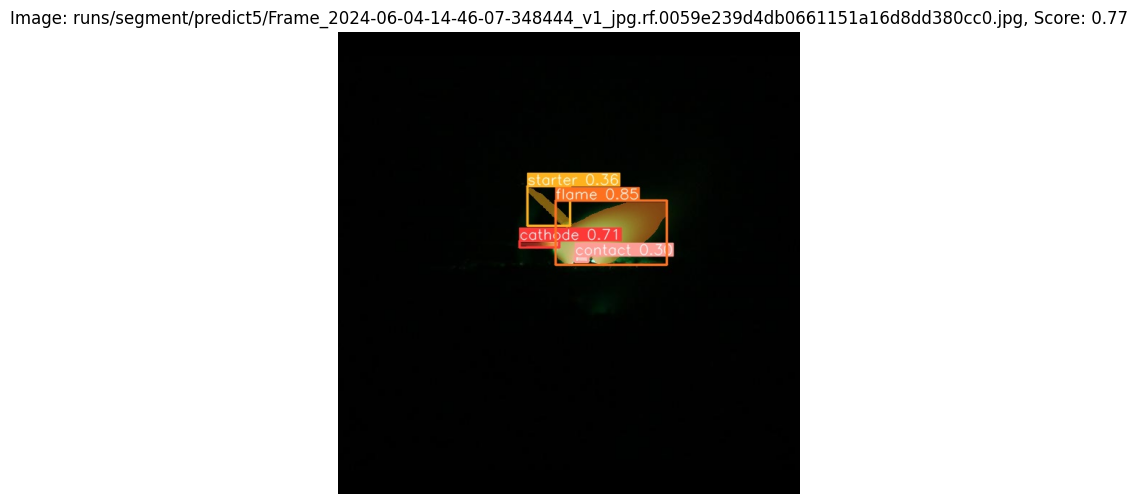

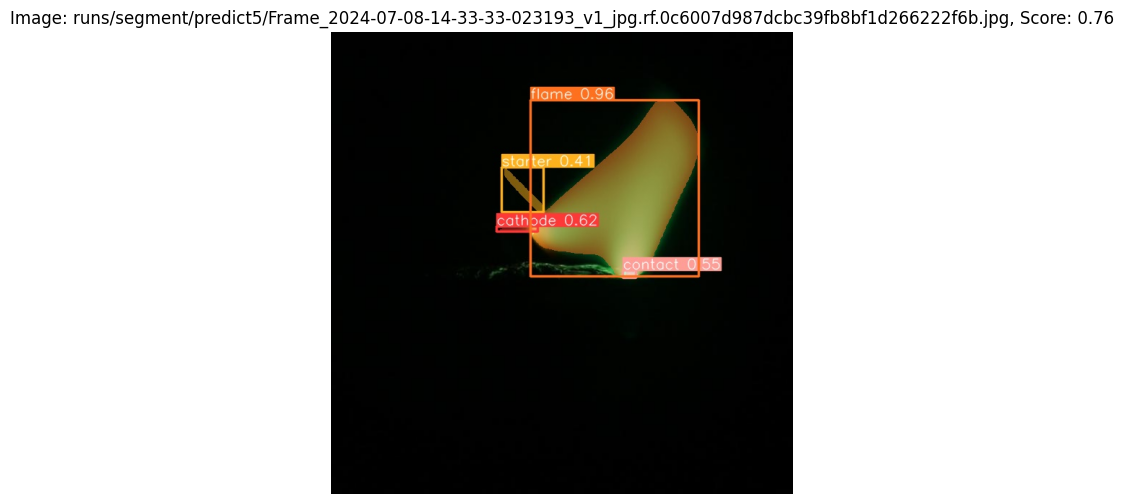

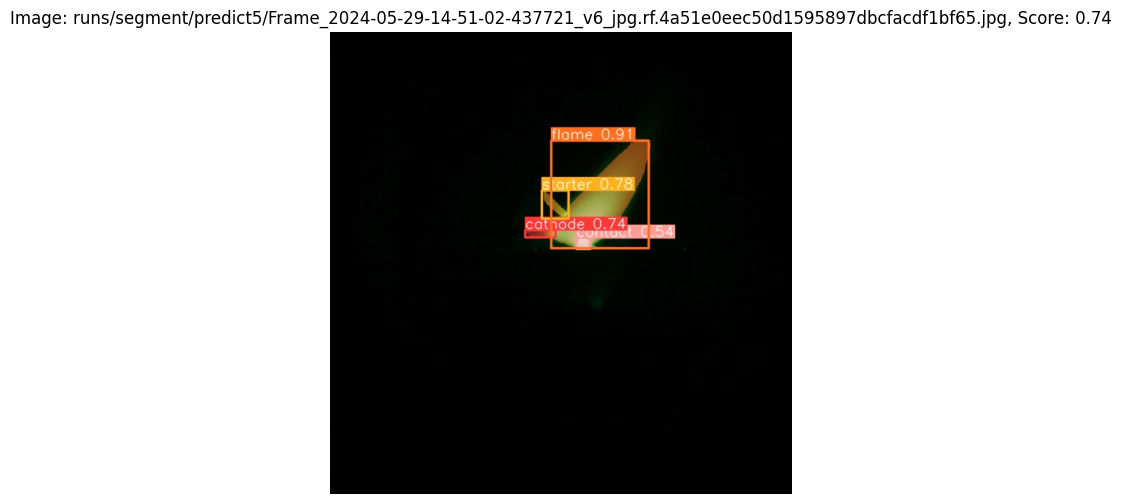

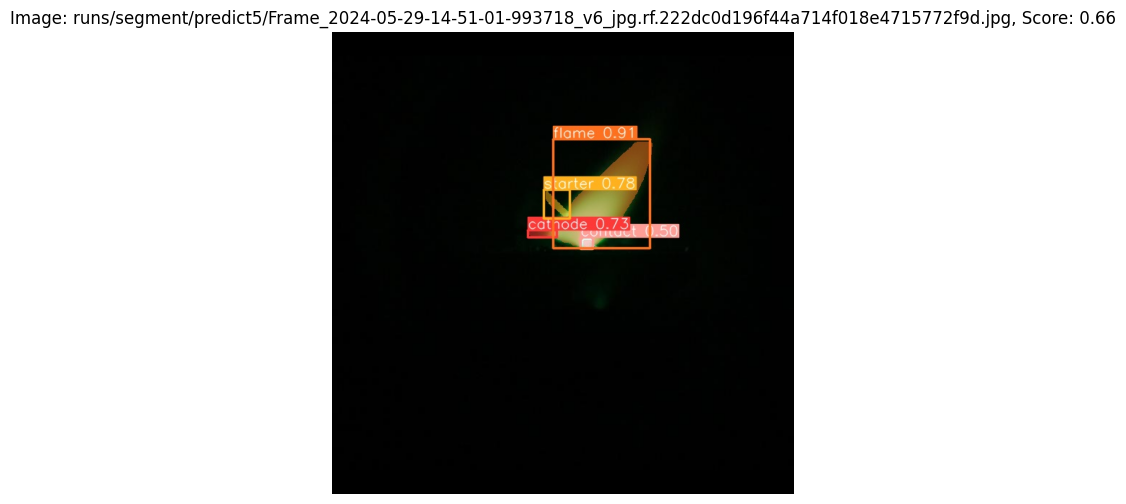

In [74]:
print("Top 5 best segmentations:")
for i, (image_path, score) in enumerate(sorted_results[:5]):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Image: {image_path}, Score: {score:.2f}")
    plt.axis('off')
    plt.show()

Top 5 worst segmentations:


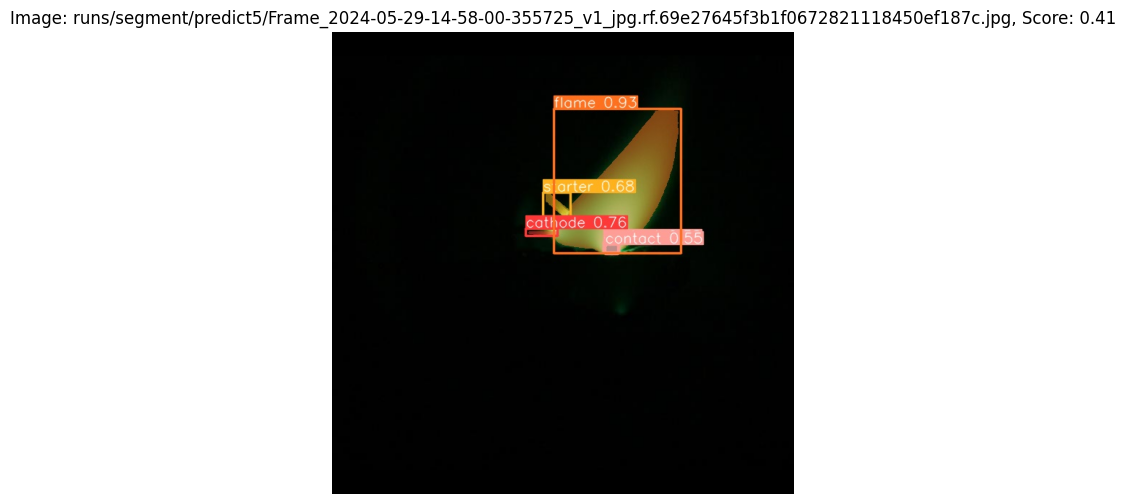

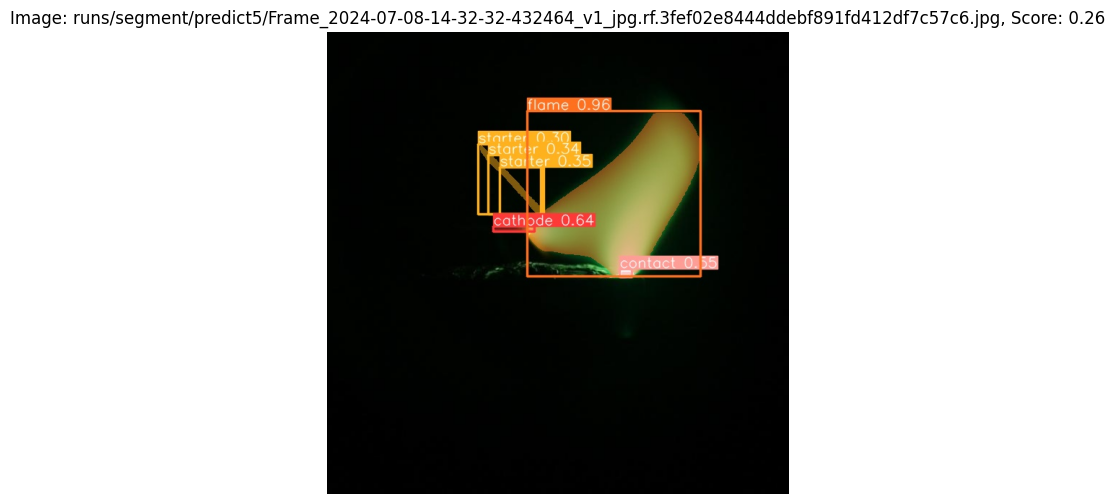

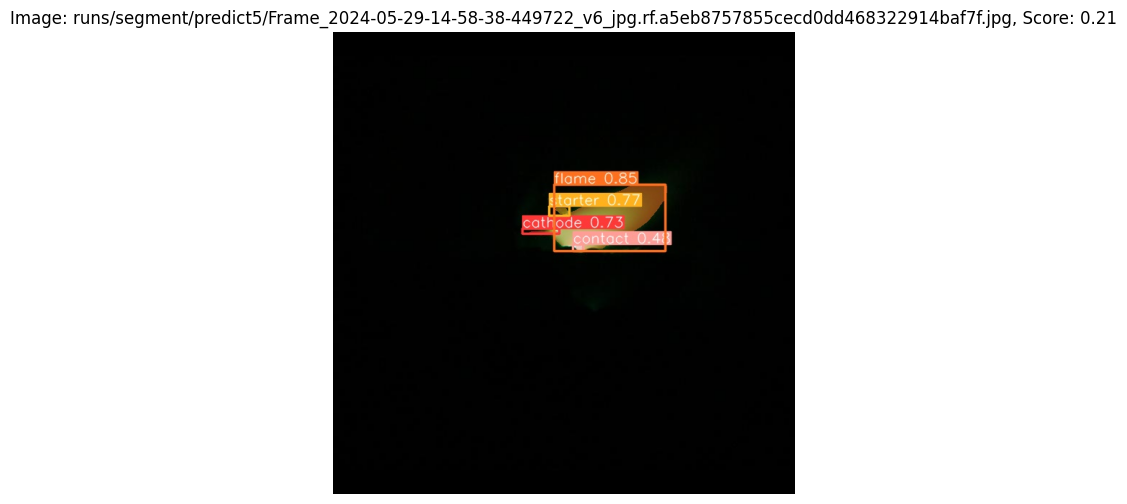

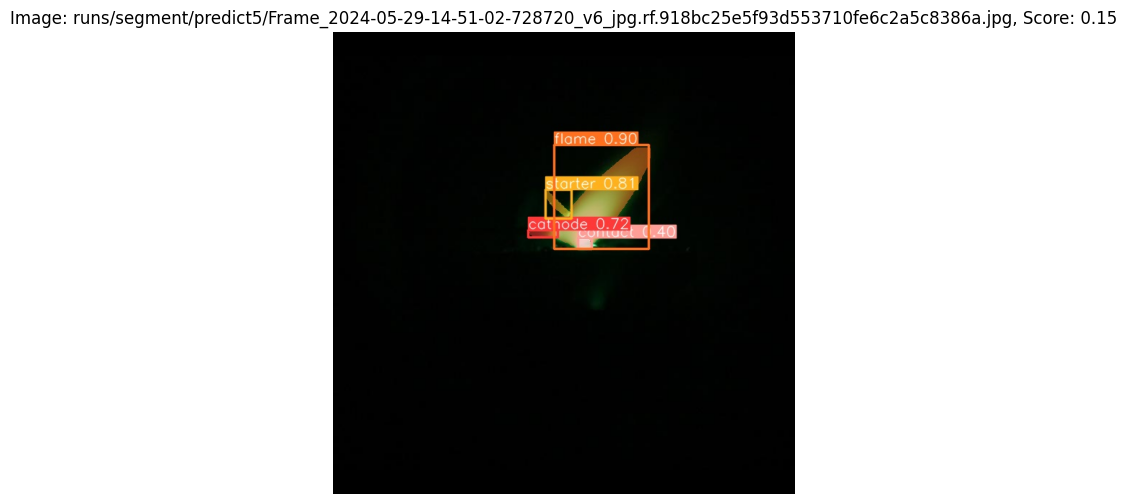

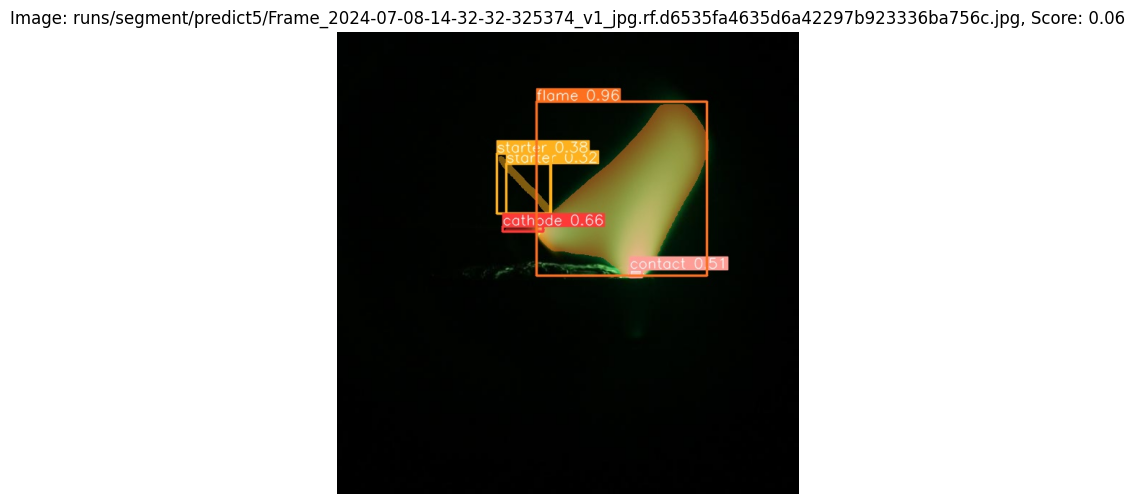

In [75]:
print("Top 5 worst segmentations:")
for i, (image_path, score) in enumerate(sorted_results[-5:]):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Image: {image_path}, Score: {score:.2f}")
    plt.axis('off')
    plt.show()